In [12]:
import os
import cv2
import json
import glob
import random
import numpy as np
import os.path as osp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
def crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, offset = 3):
    all_anno = []
    
    ### go through each game
    for anno_dir in tqdm(jersey_anno_dir): 
        
        dir_path = osp.join(output_dir, anno_dir.split('/')[-1])
        if not osp.exists(dir_path):
            os.makedirs(dir_path)
        

        ### go through each json data
        js_dir  = sorted(glob.glob(anno_dir + '/*.json'))
        for jersey_js in js_dir:

            ### Load new jersey data
            with open(jersey_js) as f:
                jersey_data = json.load(f)
                
            frame_num = osp.basename(jersey_js).replace('.json', '')

            ### Load image data
            
            img_path = os.path.join(imgs_dir, os.path.basename(anno_dir), os.path.basename(jersey_js).replace('.json', '.jpg'))
            if not os.path.exists(img_path):
                img_path = os.path.join(imgs_dir, os.path.basename(anno_dir), 'frame_' + os.path.basename(jersey_js).replace('.json', '.jpg'))
            
            
            img = cv2.imread(img_path)

            for shape in jersey_data['shapes']:

                label = shape['label']
                if 'j' in label:
                    label_split = label.split('_')
                    if len(label_split)==3:
                        track_id = label_split[1]
                        jersey_num = label_split[2]
                    elif len(label_split)==4:
                        track_id = label_split[1] + '_' + label_split[2]
                        jersey_num = label_split[-1]
                    
                    bbox_ = np.array([[int(x) for x in y] for y in shape['points']])
                    bbox_ = bbox_.flatten()

                    bbox_img = img[bbox_[1] - offset: bbox_[3] + offset, 
                                   bbox_[0] - offset: bbox_[2] + offset, :]
                    h,w,c = bbox_img.shape
                    
                    
                    output_path = osp.join(dir_path, '_'.join([str(frame_num), track_id, jersey_num]) + '.jpg')
                    
                    if h!=0 and w!=0:
                        cv2.imwrite(output_path, bbox_img)
                        all_anno.append((output_path, jersey_num))
                        
    return all_anno

### First task

In [4]:
imgs_dir = '/home/ubuntu/oljike/data/playerTrackingFrames/'
jersey_anno_dir = glob.glob('/home/ubuntu/oljike/PlayerTracking/data/second_task/*')
output_dir = '/home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops/'

In [5]:
all_anno = crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, 2)
print("Number of samples is ", len(all_anno))


Number of samples is  21513


### Second task

In [6]:
imgs_dir = '/home/ubuntu/oljike/data/playerTrackingFrames2/'
jersey_anno_dir = glob.glob('/home/ubuntu/oljike/PlayerTracking/data/third_task/*')
output_dir = '/home/ubuntu/oljike/ocr_jersey/JerseyClassifier/data/jersey_crops/'

In [7]:
all_anno.extend(crop_from_orig_anno(jersey_anno_dir, imgs_dir, output_dir, 2))
print("Number of samples is ", len(all_anno))


Number of samples is  27197


### Create the label files

In [8]:
val_dirs = ['2020.01.04-Duke_at_MiamiFL', '2019-01-12_Tennessee_at_Florida', '2020.02.03-NorthCarolina_at_FloridaState', 
           '2018.11.27-Indiana_at_Duke', '2019-02-11_Virginia_at_North_Carolina', '2019.01.22-Duke_at_Pittsburgh', 
           '2019.02.26-Duke_at_VirginiaTech', '2019.03.14-ACC-Syracuse_at_Duke', 
           '2020.02.13-Colorado_at_Oregon', '2020.02.22-Michigan_at_Purdue', 
            '2020.02.25-NorthCarolinaState_at_NorthCarolina']

f_train = open('./data/jersey_crops_train.txt', 'w')
f_val = open('./data/jersey_crops_val.txt', 'w')

for anno in tqdm(all_anno):
    dir_name = anno[0].split('/')[-2]
    
    if dir_name in val_dirs:
        f_val.writelines(','.join([anno[0], anno[1]]) + '\n')
    else:
        f_train.writelines(','.join([anno[0], anno[1]]) + '\n')
        
f_train.close()
f_val.close()

In [9]:
with open('./data/jersey_crops_train.txt') as f:
    train_data = f.readlines()
    
with open('./data/jersey_crops_val.txt') as f:
    val_data = f.readlines()
    
print("Number of train samples is {} and val samples is {}".format(len(train_data), len(val_data)))  

Number of train samples is 22098 and val samples is 5099


Label  2



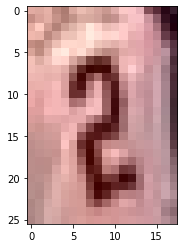

In [35]:
idx = random.choice(range(len(train_data)))
img = cv2.imread(train_data[idx].split(',')[0])
print('Label ', train_data[idx].split(',')[1])
plt.imshow(img)